# Real-Time American Sign Language Detection and Speech Synthesis

This notebook implements a real-time Word-Level American Sign Language detection system with speech output. The system will:

1. Capture video input from the webcam
2. Detect hand gestures and classify them as ASL signs
3. Convert recognized signs to text
4. Synthesize speech from the recognized text

This implementation uses a modular approach with code organized into the following modules:

- `mediapipe_utils.py`: MediaPipe detection and landmark utilities
- `data_processing.py`: Dataset creation and handling
- `model_utils.py`: Model training and evaluation
- `realtime_asl.py`: Real-time detection functionality
- `sign_model_builder.py`: LSTM model architecture

Let's get started by installing the necessary dependencies.

In [35]:
# Install requirements and run the script
!pip install -r requirements.txt
# Install tensorboard with pip ensuring it's in the correct Python environment
!pip install tensorboard
# Verify tensorboard is installed and find its location
!pip show tensorboard
# Find Python executable path which helps locate tensorboard
import sys
print(f"Python executable path: {sys.executable}")


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Name: tensorboard
Version: 2.19.0
Summary: TensorBoard lets you watch Tensors Flow
Home-page: https://github.com/tensorflow/tensorboard
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/mandev/Workspace/UNI/ChuyenNganh/venv/lib/python3.10/site-packages
Requires: absl-py, grpcio, markdown, numpy, packaging, protobuf, setuptools, six, tensorboard-data-server, werkzeug
Required-by: 
Name: tensorboard
Version: 2.19.0
Summary: TensorBoard lets you watch Tensors Flow
Home-page: https://github.com/tensorf

## Import Libraries

We'll import the necessary libraries and modules for our application.

In [18]:
import mediapipe as mp
import os
import pyttsx3
import torch
from module.helper_functions import plot_loss_curves
import datetime
from torch.utils.tensorboard import SummaryWriter

# Import our modular components
import sys
sys.path.append('./module')
from module.mediapipe_utils import setup_holistic_model
from module.data_processing import collect_sign_data
from module.model_utils import train, save_model
from module.realtime_asl import ASLDetector
from module.sign_model_builder import LSTM_Sign_Model
import torch

# Initialize MediaPipe solutions (for backward compatibility with existing code)
mp_holistic = mp.solutions.holistic

## MediaPipe Setup

We're using the modular implementation from `mediapipe_utils.py` for hand tracking and landmark detection.

In [37]:
# Initialize MediaPipe solutions for visualization if needed
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# We're using the modular implementation for these functions:
# - mediapipe_detection from module.mediapipe_utils
# - draw_landmarks from module.mediapipe_utils
# - extract_keypoints from module.mediapipe_utils
# - setup_holistic_model from module.mediapipe_utils

## Keypoint Extraction

We're using the keypoint extraction functionality from our `module.mediapipe_utils` module, which extracts useful data from MediaPipe detections for our model.

In [ ]:
# Using extract_keypoints from module.mediapipe_utils, which:
# 1. Extracts pose landmarks (33 points with x, y, z, visibility)
# 2. Extracts left hand landmarks (21 points with x, y, z) 
# 3. Extracts right hand landmarks (21 points with x, y, z)
# 4. Concatenates all points into a single feature vector

# This gives us a feature vector of length 258:

## Explore the Dataset

Let's explore the available data to understand what we're working with.

In [39]:
# List the available signs in our dataset
data_path = os.path.join('data')
actions = os.listdir(data_path)
# Remove any hidden files (like .DS_Store)
actions = [action for action in actions if not action.startswith('.')]

print(f"Available signs: {actions}")

# Get some stats about the dataset
sign_folders = os.listdir(os.path.join(data_path, actions[0]))
num_sequences = len(sign_folders)
sequence_length = len(os.listdir(os.path.join(data_path, actions[0], '0')))

print(f"Number of sequences per sign: {num_sequences}")
print(f"Frames per sequence: {sequence_length}")

Available signs: ['hello', 'iloveyou']
Number of sequences per sign: 30
Frames per sequence: 30


## Set Up Text-to-Speech Engine

We'll use pyttsx3 for speech synthesis to convert detected signs to spoken words.

In [40]:
# Initialize the text-to-speech engine
engine = pyttsx3.init()

def speak(text):
    """Convert text to speech."""
    engine.say(text)
    engine.runAndWait()

## Data Collection Function

We'll use the modular function from `module.data_processing` to collect sign language data. This will help us build a custom dataset with our own gestures.

## Use the Data Collection Function

Run the cell below to collect data for a new sign. Follow these steps:
1. Enter the name of the sign you want to collect data for (e.g., 'thankyou', 'yes', 'no')
2. When the webcam starts, position yourself in front of the camera
3. After the 5-second countdown, perform the sign at a natural pace
4. Repeat for all sequences (default: 30)

To ensure good data quality:
- Maintain good lighting
- Keep a consistent background
- Try to perform the sign consistently each time
- Vary your position slightly between sequences for better model generalization

In [12]:
# Run this cell to collect data for a new sign
new_sign = input("Enter the name of the sign you want to collect data for: ")
num_seq = int(input("Enter the number of sequences to collect (default: 30): ") or 30)
seq_length = int(input("Enter the number of frames per sequence (default: 30): ") or 30)

print(f"\nPreparing to collect data for sign: '{new_sign}'")
print("Position yourself in front of the camera.")
print("Press Enter to start...")
input()

# Create holistic model for data collection
with setup_holistic_model() as holistic:
    collect_sign_data(new_sign, holistic, num_seq, seq_length, 2)

# Update the actions list
if os.path.exists('data'):
    actions = [action for action in os.listdir('data') if not action.startswith('.')]
    print(f"Updated available signs: {actions}")


Preparing to collect data for sign: 'hello'
Position yourself in front of the camera.
Press Enter to start...


I0000 00:00:1744824633.554978 3024058 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
W0000 00:00:1744824633.652498 3037631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744824633.669486 3037631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744824633.673227 3037630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744824633.673380 3037632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744824633.673736 3037635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

Found existing sequences. Starting from sequence 33
Sequence 33 complete. Prepare for next sequence...
Sequence 34 complete. Prepare for next sequence...
Sequence 35 complete. Prepare for next sequence...
Sequence 36 complete. Prepare for next sequence...
Sequence 37 complete. Prepare for next sequence...
Sequence 38 complete. Prepare for next sequence...
Sequence 39 complete. Prepare for next sequence...
Sequence 40 complete. Prepare for next sequence...
Sequence 41 complete. Prepare for next sequence...
Data collection for sign 'hello' complete!
Collected 10 sequences with 30 frames each.
Data saved in /Users/mandev/Workspace/UNI/ChuyenNganh/data/hello
Total sequences for 'hello': 43
Updated available signs: ['hello', 'iloveyou']


## Train with Separate Training and Testing Data

If you have separate datasets for training and testing, you can use the following function to train your model using both datasets.

In [13]:
import sys
sys.path.append('./module')
import torch
from module.data_processing import  organize_data_for_testing, create_dataloaders
from module.model_utils import train, save_model, plot_loss_curves
from module.realtime_asl import ASLDetector
from module.sign_model_builder import LSTM_Sign_Model
organize_data_for_testing(train_split=0.8)

Data organized into data_train and data_test directories
Training data: 80%, Testing data: 20%


## TensorBoard Setup

We'll use TensorBoard for visualizing our training metrics. This provides a much more interactive way to track model performance than static plots.

In [14]:
# Create timestamp for unique run identification
def get_timestamp():
    return datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Function to create a TensorBoard writer with timestamp
def create_tensorboard_writer(base_dir="runs"):
    timestamp = get_timestamp()
    log_dir = os.path.join(base_dir, timestamp)
    os.makedirs(log_dir, exist_ok=True)
    return SummaryWriter(log_dir), timestamp

In [ ]:
# Create new dataloaders with our fixed implementation
train_dir = "data_train"
test_dir = "data_test"
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
)

# Check if dataloaders are empty or have issues
print(f"Train dataloader length: {len(train_dataloader)}")
print(f"Test dataloader length: {len(test_dataloader)}")

# Check first batch in each dataloader
for batch_idx, (data, target) in enumerate(train_dataloader):
    print(f"Train batch {batch_idx}: data shape = {data.shape}, target shape = {target.shape}")
    break  # Just check the first batch
    
for batch_idx, (data, target) in enumerate(test_dataloader):
    print(f"Test batch {batch_idx}: data shape = {data.shape}, target shape = {target.shape}")
    break  # Just check the first batch
    
# Update the model for the correct number of classes
NUM_EPOCHS = 5
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001
INPUT_SIZE = 258  # Updated: Pose (33*4) + Left Hand (21*3) + Right Hand (21*3) = 132 + 63 + 63 = 258

# Initialize model using our modular structure
model = LSTM_Sign_Model(
    input_size=INPUT_SIZE, 
    hidden_size=HIDDEN_UNITS,
    num_layers=1,  # Setting num_layers to 1 instead of NUM_EPOCHS which was incorrect
    num_classes=len(class_names) 
)
        
# Make sure model is on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Train dataloader length: 3
Test dataloader length: 1
Train batch 0: data shape = torch.Size([32, 30, 1662]), target shape = torch.Size([32])
Test batch 0: data shape = torch.Size([32, 30, 1662]), target shape = torch.Size([32])


 20%|██        | 1/5 [00:00<00:01,  2.39it/s]

Epoch: 1 | train_loss: 0.6958 | train_acc: 0.4225 | test_loss: 0.6937 | test_acc: 0.4375


 40%|████      | 2/5 [00:00<00:00,  3.07it/s]

Epoch: 2 | train_loss: 0.6918 | train_acc: 0.5493 | test_loss: 0.6923 | test_acc: 0.5625


 60%|██████    | 3/5 [00:00<00:00,  3.29it/s]

Epoch: 3 | train_loss: 0.6913 | train_acc: 0.5915 | test_loss: 0.6909 | test_acc: 0.5625


 80%|████████  | 4/5 [00:01<00:00,  3.43it/s]

Epoch: 4 | train_loss: 0.6890 | train_acc: 0.5915 | test_loss: 0.6895 | test_acc: 0.5625


100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

Epoch: 5 | train_loss: 0.6873 | train_acc: 0.5775 | test_loss: 0.6882 | test_acc: 0.5625
Model saved as 'model/sign_language_model_20250417-003254.pth'
Model saved to model/sign_language_model_20250417-003254.pth
Model saved as 'model/sign_language_model.pth'


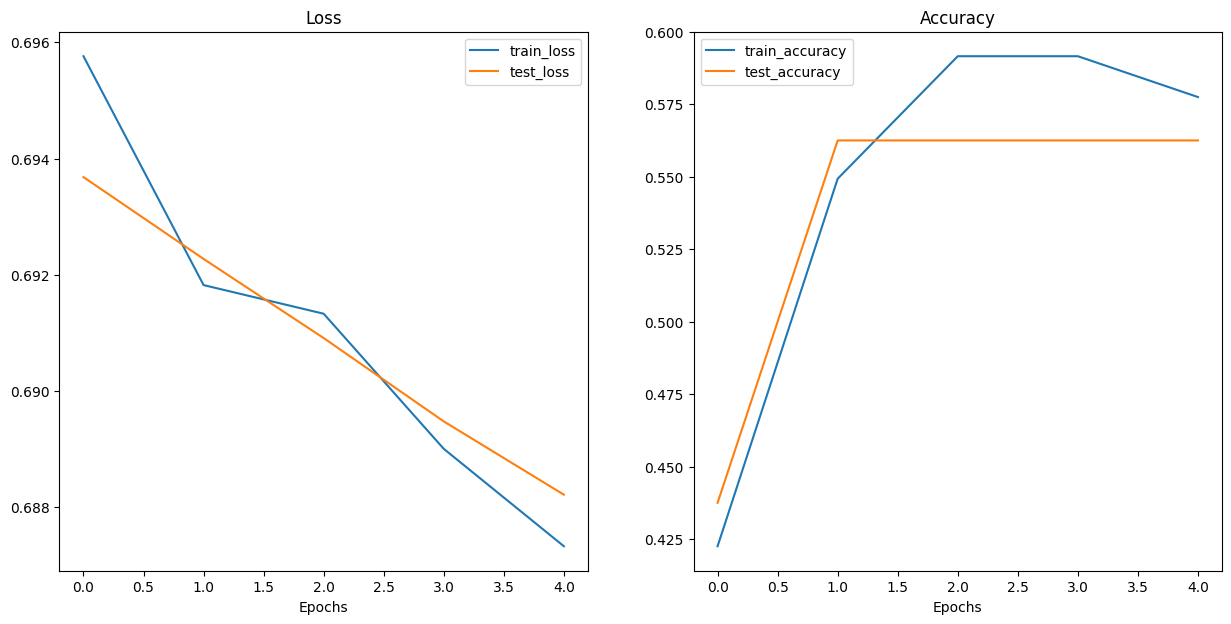

In [16]:
# Use the enhanced train_with_tensorboard function from module.model_utils
from module.model_utils import  save_model

# Train the model with the enhanced TensorBoard support
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=criterion,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
    writer=writer
)

# Save the model with timestamp
model_save_path = f'model/sign_language_model_{timestamp}.pth'
save_model(
    model=model,
    path=model_save_path,
)
print(f"Model saved to {model_save_path}")

# Also save as the default model for easier loading
save_model(
    model=model,
    path='model/sign_language_model.pth',
)

# Plot loss curves
from module.helper_functions import plot_loss_curves
plot_loss_curves(results)

## Launch TensorBoard

Run the cell below to launch TensorBoard. You can view the training metrics in an interactive dashboard.

In [11]:
# Alternative ways to run TensorBoard

# Method 1: Using %tensorboard magic command (already tried)
tb_path = os.path.join(os.getcwd(), 'runs')
print(f"Launching TensorBoard from directory: {tb_path}")

try:
    %load_ext tensorboard
    %tensorboard --logdir=runs
except Exception as e:
    print(f"Magic command failed: {str(e)}")

# Method 2: Find the tensorboard executable and set it explicitly
import sys
import subprocess
from shutil import which

# Find Python's site-packages directory where tensorboard should be installed
python_exec = sys.executable
print(f"Python executable: {python_exec}")

# Try to find tensorboard using the which command
tb_path_exec = which('tensorboard')
if tb_path_exec:
    print(f"Found tensorboard at: {tb_path_exec}")
    # Set the environment variable
    import os
    os.environ['TENSORBOARD_BINARY'] = tb_path_exec
    # Try the magic command again
    try:
        %tensorboard --logdir=runs
    except Exception as e:
        print(f"Still couldn't launch tensorboard: {e}")
else:
    print("Could not find tensorboard executable. Installing it directly:")
    !{python_exec} -m pip install -U tensorboard

# Method 3: Launch tensorboard through Python API
try:
    from tensorboard import program
    tb = program.TensorBoard()
    tb.configure(argv=[None, '--logdir', tb_path])
    url = tb.launch()
    print(f"TensorBoard started at {url}")
except Exception as e:
    print(f"Failed to launch TensorBoard through API: {e}")

# Method 4: Run tensorboard as a subprocess
try:
    print("Starting TensorBoard as a subprocess...")
    !{python_exec} -m tensorboard.main --logdir={tb_path}
except Exception as e:
    print(f"Failed to start TensorBoard as subprocess: {e}")

print("")
print("If TensorBoard still doesn't launch, try running this command in your terminal:")
print(f"cd {os.getcwd()} && tensorboard --logdir=runs")

Launching TensorBoard from directory: /Users/mandev/Workspace/UNI/ChuyenNganh/runs


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

Python executable: /Users/mandev/Workspace/UNI/ChuyenNganh/venv/bin/python
Could not find tensorboard executable. Installing it directly:

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
TensorBoard started at http://localhost:6006/
Starting TensorBoard as a subprocess...
TensorBoard started at http://localhost:6006/
Starting TensorBoard as a subprocess...
TensorFlow installation not found - running with reduced feature set.
TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.19.0 at http://localhost:6007/ (Press CTRL+C to quit)
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.19.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C
^C


## Real-Time Detection with PyTorch

Now, let's implement the real-time detection using our PyTorch model and the modular ASLDetector class.

In [17]:
# Create a detector instance using our modular implementation
# Use the latest trained model by default or specify a particular timestamp model
# model_path = 'model/sign_language_model.pth'  # Default model path

# Uncomment to use a specific timestamped model
model_path = f'model/sign_language_model_{timestamp}.pth'

detector = ASLDetector(model_path=model_path, 
                      threshold=0.7,
                      sequence_length=30, 
                      device=device)

# Start real-time detection
detector.detect_in_realtime(camera_idx=2)

Model loaded with weights_only=False for backward compatibility
Loaded model from model/sign_language_model_20250417-003254.pth
Detected actions: ['hello', 'iloveyou']


I0000 00:00:1744824789.222417 3024058 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
W0000 00:00:1744824789.334104 3041673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744824789.349790 3041667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744824789.353210 3041667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744824789.353436 3041673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744824789.353745 3041669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

KeyboardInterrupt: 

## Model Management

The following cell lets you list and load models saved with timestamps. This is useful when you have trained multiple models and want to compare their performance.

In [10]:
# List all saved models
model_dir = 'model'
model_files = [f for f in os.listdir(model_dir) if f.startswith('sign_language_model_') and f.endswith('.pth')]
print("Available models:")
for i, model_file in enumerate(model_files):
    timestamp = model_file.replace('sign_language_model_', '').replace('.pth', '')
    print(f"{i+1}. Model trained at {timestamp}")

# Function to load a specific model by timestamp
def load_model_by_timestamp(timestamp):
    model_path = f'model/sign_language_model_{timestamp}.pth'
    model = torch.load(model_path)
    print(f"Loaded model trained at {timestamp}")
    return model

# Example usage:
# selected_timestamp = "20250416-123456"  # Replace with an actual timestamp
# loaded_model = load_model_by_timestamp(selected_timestamp)

Available models:
1. Model trained at 20250416-230749
2. Model trained at 20250416-212336
3. Model trained at 20250416-212916
4. Model trained at 20250416-212634


## Future Improvements

Here are some potential improvements for the application:

1. **Sentence Formation**: Implement grammar rules to form proper sentences from detected signs.
2. **Continuous Sign Language Recognition**: Improve the model to handle continuous signing.
3. **User Interface**: Create a more user-friendly interface with settings for sensitivity and speech voice.
4. **Mobile Application**: Convert the system to a mobile application for wider accessibility.
5. **Expanded Vocabulary**: Train the model on a larger dataset to recognize more signs.
6. **Two-Way Translation**: Add speech-to-sign functionality for two-way communication.

## Conclusion

This notebook demonstrates a real-time American Sign Language detection and speech synthesis system. The application uses:

1. MediaPipe for hand tracking and landmark detection
2. PyTorch for sign classification using an LSTM model
3. OpenCV for video capture and visualization
4. pyttsx3 for text-to-speech conversion

The system can detect Word-Level ASL signs and convert them to speech in real-time, providing a valuable tool for sign language communication.